In [1]:
import os
import sys
from pathlib import Path
import torchvision
from matplotlib import pyplot as plt

sys.path.append("../")

from utils.dataloader import Vectorize_WSIs

parent_path = Path("/localscratch")
imgs_path = parent_path / Path([p for p in os.listdir(parent_path) if "ramanav" in p ][0]) / "SSL_training"

dataset = Vectorize_WSIs(
                        image_pth=str(imgs_path / "images/122S.tif"),
                        mask_pth=str(imgs_path / "masks"),
                        template_pth=str(imgs_path.parent/"by_class"),
                        tile_h=256,
                        tile_w=256,
                        tile_stride_factor_h=3,
                        tile_stride_factor_w=3,
                        colors=[("black","#28282B"),("#002d04","#2a7e19"),("#000133","skyblue"),("#1f0954","#6d5caf"),("#a90308","#ff000d")],
                        transform=torchvision.transforms.ToTensor()
)

Loading wsis.. 1/1: : 1it [00:22, 22.43s/it]


Loading the data...


100%|██████████| 10000/10000 [00:05<00:00, 1895.92it/s]


In [3]:
master_path = list(Path("/localscratch/ramanav.38626443.0/by_class").glob("**/*.png"))

In [7]:
len(master_path)

1545923

In [2]:
dataset.ink_templates[0]

In [2]:
all_imgs = dataset.all_image_tiles_hr

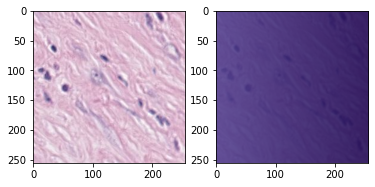

In [14]:
idx = 1
fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(all_imgs[idx])
plt.subplot(1,2,2)
plt.imshow(dataset[idx][0].permute(1,2,0))

In [3]:
import trainer
import sys
sys.path.append("../")
import utils
from pathlib import Path

parent_path = Path("/localscratch")
imgs_path = parent_path / Path([p for p in os.listdir(parent_path) if "ramanav" in p ][0]) / "SSL_training"

dataset = trainer.Dataset.create("ink",
                                 path=str(imgs_path),
                                 test_batch_size=64,
                                 train_batch_size=64,
                                image_pth=str(imgs_path / "images/122S.tif"),
                                mask_pth=str(imgs_path / "masks"),
                                template_pth=str(imgs_path.parent/"by_class"),
                                tile_h=256,
                                tile_w=256,
                                tile_stride_factor_h=3,
                                tile_stride_factor_w=3,
                                colors=[("black","#28282B"),("#002d04","#2a7e19"),("#000133","skyblue"),("#1f0954","#6d5caf"),("#a90308","#ff000d")],
                                train_split=0.8
)

Loading wsis.. 1/1: : 1it [00:16, 16.93s/it]


Loading the data...


100%|██████████| 10000/10000 [00:03<00:00, 2544.08it/s]
Loading wsis.. 1/1: : 1it [00:16, 16.05s/it]


Loading the data...


100%|██████████| 10000/10000 [00:03<00:00, 2590.36it/s]
/home/ramanav/projects/rrg-amartel/ramanav/Projects/InkFilter/ink/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
from tqdm import tqdm
for img,label in tqdm(dataset.train_loader):
    pass

100%|██████████| 42/42 [00:52<00:00,  1.24s/it]


In [4]:
dataset.trainset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 1)

In [15]:
dataset.ink_generator.get_plots(all_imgs[56])

TypeError: unsupported operand type(s) for /: 'int' and 'builtin_function_or_method'

<Figure size 720x720 with 0 Axes>

In [5]:
dataset[idx]

(tensor([[[0.8431, 0.8588, 0.8784,  ..., 0.9176, 0.9333, 0.9529],
          [0.8118, 0.8314, 0.8627,  ..., 0.9137, 0.9333, 0.9490],
          [0.7804, 0.8000, 0.8314,  ..., 0.9059, 0.9176, 0.9333],
          ...,
          [0.9176, 0.8784, 0.8471,  ..., 0.8431, 0.8431, 0.8510],
          [0.9294, 0.8941, 0.8706,  ..., 0.8667, 0.8431, 0.8353],
          [0.9294, 0.9059, 0.8824,  ..., 0.9020, 0.8824, 0.8706]],
 
         [[0.7333, 0.7451, 0.7608,  ..., 0.8275, 0.8510, 0.8706],
          [0.7020, 0.7176, 0.7451,  ..., 0.8235, 0.8431, 0.8667],
          [0.6824, 0.6902, 0.7216,  ..., 0.8078, 0.8275, 0.8431],
          ...,
          [0.7843, 0.7451, 0.7098,  ..., 0.7490, 0.7490, 0.7569],
          [0.7961, 0.7608, 0.7333,  ..., 0.7725, 0.7490, 0.7412],
          [0.8039, 0.7765, 0.7529,  ..., 0.8078, 0.7882, 0.7765]],
 
         [[0.8196, 0.8314, 0.8549,  ..., 0.8980, 0.9176, 0.9373],
          [0.7882, 0.8039, 0.8392,  ..., 0.8941, 0.9137, 0.9333],
          [0.7647, 0.7765, 0.8118,  ...,

In [18]:
dataset[15]

(tensor([[[0.7373, 0.7373, 0.7490,  ..., 0.8588, 0.8863, 0.9176],
          [0.7137, 0.7373, 0.7451,  ..., 0.8745, 0.8667, 0.8667],
          [0.6941, 0.7255, 0.7176,  ..., 0.8863, 0.8471, 0.8235],
          ...,
          [0.8392, 0.8157, 0.8078,  ..., 0.9255, 0.8745, 0.8235],
          [0.8235, 0.8039, 0.7961,  ..., 0.9176, 0.8824, 0.8431],
          [0.8078, 0.7882, 0.7882,  ..., 0.9333, 0.9176, 0.8980]],
 
         [[0.6078, 0.6078, 0.6078,  ..., 0.7255, 0.7333, 0.7647],
          [0.5843, 0.6078, 0.6039,  ..., 0.7373, 0.7137, 0.7137],
          [0.5647, 0.5961, 0.5765,  ..., 0.7451, 0.6941, 0.6706],
          ...,
          [0.6824, 0.6588, 0.6510,  ..., 0.7804, 0.7412, 0.6863],
          [0.6588, 0.6392, 0.6314,  ..., 0.7804, 0.7529, 0.7137],
          [0.6392, 0.6196, 0.6118,  ..., 0.8039, 0.8000, 0.7804]],
 
         [[0.7922, 0.7922, 0.7882,  ..., 0.8196, 0.8392, 0.8784],
          [0.7686, 0.7843, 0.7843,  ..., 0.8314, 0.8196, 0.8275],
          [0.7412, 0.7725, 0.7490,  ...,